In [ ]:
#import MobileNet model
from tensorflow.keras.applications import MobileNet


#set default image size
img_rows, img_cols = 224,224

MobileNet = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape = (img_rows,img_cols,3))


#use previous weights 
for layer in MobileNet.layers:
  layer.trainable = False

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model


#top layer according to our custom need
def addTopModelMobileNet(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(512,activation='relu')(top_model)
  top_model = Dense(1,activation='sigmoid')(top_model)
  return top_model

In [48]:
num_classes = 1

FC_Head = addTopModelMobileNet(MobileNet,num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#train path
train_dir = '/Dataset/Train'
#validation path
validation_dir = '/Dataset/Test'

#image augmentation for trainset and normalize data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=.3,
                                   height_shift_range=.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
#normalize validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

#create training data
train = train_datagen.flow_from_directory(train_dir,
                                          target_size=(img_rows,img_cols),
                                          batch_size=batch_size,
                                          class_mode = 'binary')

#create validation data
validation = validation_datagen.flow_from_directory(validation_dir,
                                                     target_size=(img_rows,img_cols),
                                                     batch_size=batch_size,
                                                     class_mode = 'binary',
                                                     shuffle=False)

Found 266 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#checkpoint to save the model auto
ckeckpoint = ModelCheckpoint('face_mask_finale.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

#earlystop to stop overfitting
earlystop = EarlyStopping(monitor='val_loss',
                          mode='min',
                          patience=5,
                          verbose=1)


#reduce learning rate overtime
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              varbose=1,
                              min_delta=0.0001)

callbacks = [ckeckpoint, earlystop, reduce_lr]

nb_train_samples = 266 
nb_test_samples = 41
batch_size = 32
epochs = 25


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#train the model
model.fit(train, validation_data=validation,
          steps_per_epoch = nb_train_samples//batch_size,
          epochs = epochs,
          callbacks=callbacks,
          validation_steps = nb_test_samples//batch_size)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1/25
8/8 [==============================] - ETA: 0s - loss: 1.3184 - accuracy: 0.4844
Epoch 00001: val_loss improved from inf to 0.31570, saving model to face_mask_finale.h5
8/8 [==============================] - 11s 1s/step - loss: 1.3184 - accuracy: 0.4844 - val_loss: 0.3157 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/25
8/8 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.9145
Epoch 00002: val_loss improved from 0.31570 to 0.03367, saving model to face_mask_finale.h5
8/8 [==============================] - 10s 1s/step - loss: 0.3067 - accuracy: 0.9145 - val_loss: 0.0337 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/25
8/8 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9615
Epoch 00003: val_loss improved from 0.03367 to 0.00567, saving model to face_mask_finale.h5
8/8 [==============================] - 10s 1s/step - loss: 0.1140 - accuracy: 0.9615 - val_loss: 0.0057 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/25
8/8 [================

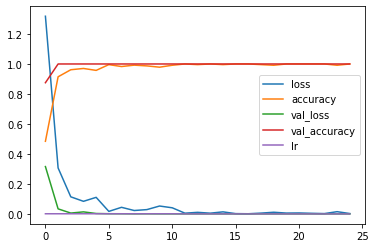

In [ ]:
#visualize model result

import pandas as pd
loss = pd.DataFrame(model.history.history)
loss.plot()

In [ ]:
#predict on validation data
pred = model.predict(validation)

In [ ]:
#reshape predicted data to match validation class

pred_reshaped = pred.reshape(41)

In [ ]:
#make our prediction result into 0 or 1
# 0 indicates With Mask and 1 indicates No Mask

pred_real = []
for x in pred_reshaped:
  if x > .5:
    x = 1
  else:
    x = 0
  pred_real.append(x)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(validation.classes,pred_real))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        19

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



In [ ]:
confusion_matrix(validation.classes,pred_real)

array([[22,  0],
       [ 0, 19]])